# Ciência dos Dados - 2020 / Segundo Semestre

## Projeto 2

# Entrega 1

In [98]:
import pandas as pd
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

"""
Grupo:
Carlos Simodo
Lai Aguiar

Abre csv disponível no repositório https://github.com/seade-R/dados-covid-sp
público com dados da covid no estado de São Paulo
"""
data = pd.read_csv('casos_obitos_doencas_preexistentes.csv', sep=';')


# Eliminamos a coluna codigo_ibge por ela não nos trazer uma informação relevante,
# já que trabalhamos com a probabilidade de óbito a partir de comorbidades, local
# de diagnóstico, idade, sexo 
del data['codigo_ibge']

# Eliminamos as linhas da tabela onde temos informações repetidas e 
# incoerentes como idade = 120 anos
# Também eliminamos todos identificadores IGNORADO ou vazios
data = data[data['idade'] < 120]

data = data.applymap(lambda x: np.nan if x == 'IGNORADO' else x).dropna()
# data = data[data != np.nan()]
# data = data.replace('IGNORADO', 'NÃO')
# data = data.replace('NaN', 'NÃO')

data.to_csv('casos_obitos_doencas_preexistentes_tratado.csv', sep=';')



data_copy = data.copy()
train = data_copy.sample(frac=0.75, random_state=0)
test = data_copy.drop(train.index)




# Entrega 2

#### Para analisarmos os dados, decidimos começar pela idade para ter uma ideia do perfil dos entrevistados

In [99]:
media_idade = data['idade'].mean()
mediana_idade = data['idade'].median()
moda_idade = data['idade'].mode()
var_idade = data['idade'].var()
std_idade = data['idade'].std()

print('A média de idade no nosso dataset é :', media_idade, '')
print('A variância da idade no nosso dataset é: ', var_idade)
print('O desvio padrão da idade no nosso dataset é: ', std_idade, 'que significa que os dados não estão muito espalhados')
print('A mediana da idade no nosso dataset é: ', mediana_idade)
print('A moda de idade no nosso dataset é: ', moda_idade, 'uma idade alta muito frequente')

A média de idade no nosso dataset é : 64.1313711414214 
A variância da idade no nosso dataset é:  278.48973722163
O desvio padrão da idade no nosso dataset é:  16.688011781564335 que significa que os dados não estão muito espalhados
A mediana da idade no nosso dataset é:  66.0
A moda de idade no nosso dataset é:  0    66.0
dtype: float64 uma idade alta muito frequente


#### Percebemos que tanto a idade média quanto a mediana e a moda estão muito altas, indicando que a maioria dos entrevistados possuem idades elevadas.Tendo analisado um pouco sobre os entrevistados, decidimos verificar a influência de cada doenca pré existente com o óbito.

In [100]:
data_temp = data.replace({'NÃO': 0, 'SIM': 1})
print(data_temp.corr())

                            idade     obito  ...  puerpera  sindrome_de_down
idade                    1.000000  0.326266  ... -0.060185         -0.055259
obito                    0.326266  1.000000  ... -0.024757         -0.028991
asma                    -0.076165 -0.041401  ... -0.013123          0.007938
cardiopatia              0.228733  0.081077  ... -0.046580         -0.026717
diabetes                 0.068645  0.018532  ... -0.027185         -0.002751
doenca_hematologica      0.006296  0.018731  ...  0.046011          0.079490
doenca_hepatica         -0.007377  0.023760  ... -0.007204          0.075423
doenca_neurologica       0.151600  0.137592  ...  0.003704          0.050271
doenca_renal             0.059255  0.075340  ... -0.016448          0.018991
imunodepressao          -0.028348  0.055151  ...  0.018620          0.036405
obesidade               -0.179205 -0.026501  ... -0.019550          0.009945
outros_fatores_de_risco -0.022793  0.054973  ... -0.031097         -0.007847

#### Com a matriz de correlação, podemos visualizar a correlação entre as doencas e o numero de mortos. Embora gráficos de dispersão sejam ótimas ferramentas para isso, decidimos nao plotar gráficos com o scatter plot, uma vez que ele é melhor para variáveis continuas, e nossos dados são em sua maioria variáveis binárias

#### Tendo descoberta as correlações, buscamos descobrir a prevalencia das doenças nos entrevistados, e para isso utilizamos gráficos de setores(pizza) para termos uma ideia mais geral, apenas da proporção.

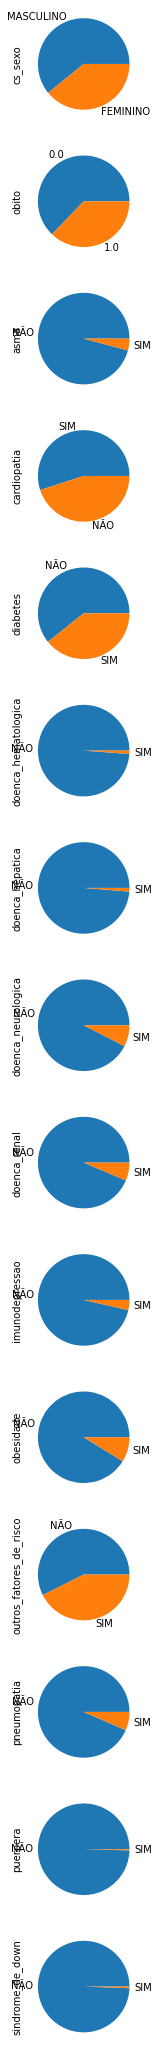

In [101]:
plt.figure()
i=1
#print(data.columns)
#lista para retirar dados que não pertecem a essa parte da analise
lista_no_plot = ['nome_munic', 'idade', 'data_inicio_sintomas','diagnostico_covid19']
for item in data.columns:
  if item not in (lista_no_plot):
    a = plt.subplot(16,1,i)
    temp_frame = data[item].value_counts()
    plot = temp_frame.plot.pie(y=item, figsize=(40, 40),ax=a)
    i+=1
  

#### Com os dados obtidos acima, temos uma noção do perfil dos pacientes,que possuem em media uma idade mais elevada e são em sua maioria homens, da prevalencia das doenças,sendo a mais comum a cardiopatia, e a correlação que essas doencas posssuem com a morte, que afetou cerca de um terço dos entrevistados. Assim, consideramos que a análise inicial está completa.


### Entrega 3

In [102]:
obitou = train[train['obito']==1]
viveu = train[train['obito'] != 1]

# probabilidades de ter cada doenca, dado que morreu
dict_doenca_morreu = dict()
for column in obitou.columns:
    if column not in (lista_no_plot):
        dict_doenca_morreu[column] = len(obitou[obitou[column]=='SIM'])/len(obitou)

# probabilidades de ter cada doenca, dado que sobreviveu
dict_doenca_viveu = dict()
for column in viveu.columns:
    if column not in (lista_no_plot):
        dict_doenca_viveu[column] = len(viveu[viveu[column]=='SIM'])/len(viveu)

# probabilidade de ter a doenca
dict_doenca = dict()
for column in train.columns:
    if column not in (lista_no_plot):
        dict_doenca[column] = len(train[train[column]=='SIM'])/len(data)

# probabilidade de morrer do covid
prob_morrer = len(obitou)/len(train)
prob_viver = 1 - prob_morrer

# calculo da probabilidade de morrer dado que tem uma doenca
# Aqui foio calculada a probabilidade independente, porém sabemos que não é o cálculo definitivo,
# pois precisamos da probabilidade combinada
prob_bayes = dict()
for doenca in train.columns:
    if doenca not in (lista_no_plot):
        if dict_doenca[doenca]>0:
            prob_bayes[doenca] = dict_doenca_morreu[doenca]*prob_morrer / dict_doenca[doenca]
        else: prob_bayes[doenca] = 0


# prob final

def calcula(lista_doencas):
    multip = prob_morrer
    cte_normalizadora_v = prob_viver
    cte_normalizadora_m = prob_morrer

    for doenca in lista_doencas:
        multip = multip*dict_doenca_morreu[doenca]

        cte_normalizadora_v  = cte_normalizadora_v*dict_doenca_viveu[doenca]
        cte_normalizadora_m  = cte_normalizadora_m*dict_doenca_morreu[doenca]
    
    cte_normalizadora = cte_normalizadora_v + cte_normalizadora_m
    prob_final = multip/cte_normalizadora

    return prob_final

# Teste da função de calculo da probabilidade de óbito

pacientes = {'paciente 1': ['cardiopatia', 'pneumopatia'],
             'paciente 2': ['asma', 'diabetes', 'imunodepressao', 'cardiopatia'],
             'paciente 3': ['pneumopatia']}


for paciente in pacientes.keys():
    print("A probabilidade do {} morrer, dado que ele tem {} é de {}".format(paciente, str(pacientes[paciente])[1:-1].replace("""'""", ""), calcula(pacientes[paciente])))


df = data
columns = data.columns

lista_prob=[]

for index, row in df.iterrows(): 
    lista_doencas = []
    row['prob'] = 0
    for column in columns:
       if column not in lista_no_plot:
            if row[column] == 'SIM':
              lista_doencas.append(column)
              #print(lista)
    lista_prob.append(float(calcula(lista_doencas)))


df['Probabilidade'] = lista_prob
df

def verifica_morte(prob):
  α=0.5
  if prob>α:
    return 'SIM'
  else:
    return 'NÃO'

df["Classificacao"] = df["Probabilidade"].apply(verifica_morte)
df

pd.crosstab(df.obito,df.Classificacao, normalize="columns")*100

A probabilidade do paciente 1 morrer, dado que ele tem cardiopatia, pneumopatia é de 0.5625328703237097
A probabilidade do paciente 2 morrer, dado que ele tem asma, diabetes, imunodepressao, cardiopatia é de 0.4756049477464331
A probabilidade do paciente 3 morrer, dado que ele tem pneumopatia é de 0.5322580645161291


Classificacao,NÃO,SIM
obito,,
0.0,67.462139,46.128501
1.0,32.537861,53.871499


In [ ]:
# Calculo das probabilidades com o dataset de teste


